In [1]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
path = 'W:\\datasets\\asbestos\\line-segmentation\\'
os.listdir(path)

['aug_images_224',
 'aug_masks_224',
 'images',
 'macro_fullsize.xml',
 'masks',
 'v1']

In [5]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'aug_images_224':
        img_pathes = pathes
    elif folder == 'aug_masks_224':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [6]:
img_pathes[:5]

['W:\\datasets\\asbestos\\line-segmentation\\aug_images_224\\DSC05086_0.png',
 'W:\\datasets\\asbestos\\line-segmentation\\aug_images_224\\DSC05086_1.png',
 'W:\\datasets\\asbestos\\line-segmentation\\aug_images_224\\DSC05086_10.png',
 'W:\\datasets\\asbestos\\line-segmentation\\aug_images_224\\DSC05086_11.png',
 'W:\\datasets\\asbestos\\line-segmentation\\aug_images_224\\DSC05086_12.png']

In [7]:
len(img_pathes), len(lbl_pathes)

(500, 500)

In [8]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'aug_images_224':
                img_pathes = pathes
            elif folder == 'aug_masks_224':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))

        if subset == 'train':
            self.items = items[: int(0.95 * len(items))]
        elif subset == 'valid':
            self.items = items[int(0.95 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [9]:
data = Dataset(path, subset='valid', transform=None)

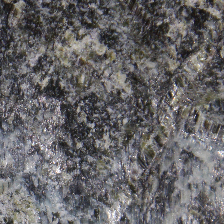

In [10]:
img, msk = data[0]
img

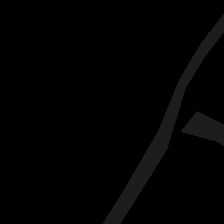

In [11]:
msk

In [12]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)

In [13]:
train_data.__len__(), valid_data.__len__()

(475, 25)

In [14]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)

In [15]:
import segmentation_models_pytorch as smp

model = smp.Unet('resnet34').to(device)

In [16]:
from torch import nn 

loss = nn.BCEWithLogitsLoss()
#loss = smp.utils.losses.BCEDiceLoss(eps=1.)
loss.__name__ = 'bce_loss'
metrics = [
    smp.utils.metrics.IoUMetric(eps=1.),
    smp.utils.metrics.FscoreMetric(eps=1.),
]

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},#-3     

    {'params': model.encoder.parameters(), 'lr': 1e-4},  #-4
])

In [17]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)


In [18]:
%%time
max_score = 0
train_logs_list = []
valid_logs_list = []
for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou']:
#         max_score = valid_logs['iou']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')
        

    #if i == 5:
     #   optimizer.param_groups[1]['lr'] = 1e-5
      #  print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
valid: 100%|███████████████████████████| 2/2 [00:00<00:00, 11.17it/s, bce_loss - 0.605, iou - 0.01062, f-score - 0.021]

Epoch: 1
valid: 100%|█████████████████████| 2/2 [00:00<00:00, 11.63it/s, bce_loss - 0.168, iou - 0.0002414, f-score - 0.0002414]

Epoch: 2
valid: 100%|████████████████████| 2/2 [00:00<00:00, 11.56it/s, bce_loss - 0.1377, iou - 0.0002408, f-score - 0.0002408]

Epoch: 3
valid: 100%|████████████████████| 2/2 [00:00<00:00, 11.70it/s, bce_loss - 0.1077, iou - 0.0002414, f-score - 0.0002414]

Epoch: 4
valid: 100%|███████████████████| 2/2 [00:00<00:00, 11.30it/s, bce_loss - 0.09031, iou - 0.0002414, f-score - 0.0002414]
Wall time: 37.2 s


In [19]:
train_bce_loss, valid_bce_loss = [], []
train_iou, valid_iou = [], []
train_f_score, valid_f_score = [], []
for i in range(len(train_logs_list)): #epochs
    train_bce_loss.append(train_logs_list[i]['bce_loss'])
    valid_bce_loss.append(valid_logs_list[i]['bce_loss'])
    train_iou.append(train_logs_list[i]['iou'])
    valid_iou.append(valid_logs_list[i]['iou'])
    train_f_score.append(train_logs_list[i]['f-score'])
    valid_f_score.append(valid_logs_list[i]['f-score'])

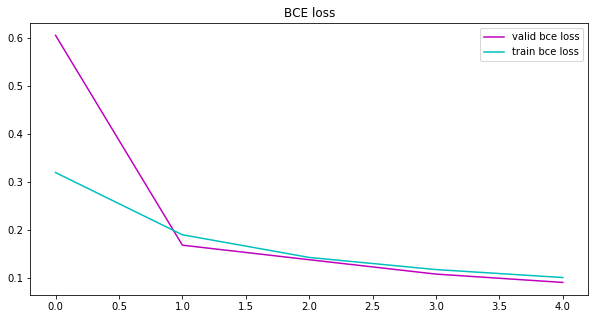

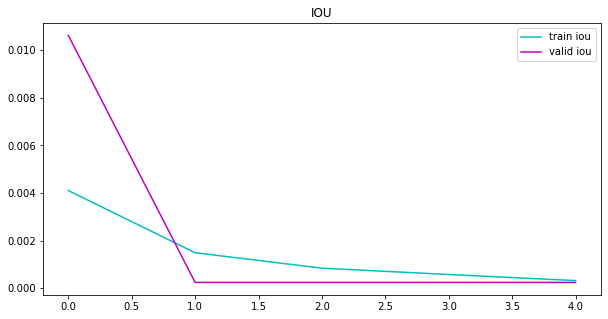

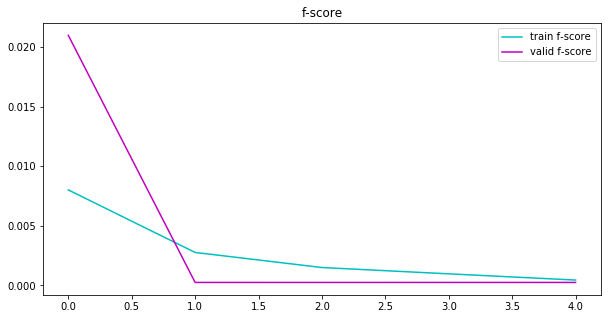

In [20]:
plt.figure(figsize=(10, 5))
plt.title("BCE loss")
plt.plot(valid_bce_loss, 'm', label='valid bce loss')
plt.plot(train_bce_loss, 'c', label='train bce loss')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("IOU")
plt.plot(train_iou, 'c', label='train iou')
plt.plot(valid_iou, 'm', label='valid iou')
plt.legend();

plt.figure(figsize=(10, 5))
plt.title("f-score")
plt.plot(train_f_score, 'c', label='train f-score')
plt.plot(valid_f_score, 'm', label='valid f-score')
plt.legend();

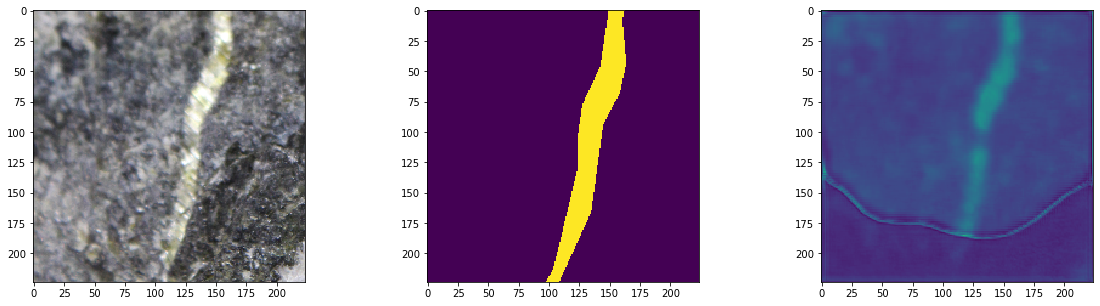

In [25]:
img, mask_true = valid_data[15]
mask_pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(132)
plt.imshow(mask_true.squeeze().numpy())
plt.subplot(133)
plt.imshow(mask_pred.squeeze().cpu().detach().numpy());
#plt.savefig('test_23_020.png')

- Если batch size увеличивать, всё становится сильно хуже
- Странное пятно